In [1]:
import random
import numpy as np
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# number of characters in a word.
# for instance abccba has nb_chars = 6
nb_chars = 4

# number of possible characters used during the encoding.
# for instance abcde leads to 01234 has nb_letters = 5
nb_letters = 26

# number of words samples to be generated 
nb_words = 30000

# percentage of words that will be used for validation
percentage_split = 0.90

# number of epochs for fitting the model training step
nb_epochs = 200

In [3]:
# total number of combinations
nb_letters**nb_chars

456976

In [4]:
def create_inputs(nb_words, nb_chars, nb_letters):
    '''Create a numpy array of nb_words rows with nb_chars columns each element
    being a random letter of nb_letters (a, b...)'''
    words = np.zeros((nb_words, nb_chars), dtype=int)
    
    for w in range(nb_words):
        optim_tentative = False
        if optim_tentative == True and w%10 != 0:
            i = random.randint(0, nb_letters-1)
            for c in range(nb_chars):
                words[w, c] = ord('a') + i
        else:
            for c in range(nb_chars):
                i = random.randint(0, nb_letters-1)
                words[w, c] = ord('a') + i
                
    return words


def encrypt(words, nb_words, nb_chars):
    '''Encrypt each element of a numpy array of nb_words rows with nb_chars 
    columns each item with a secret algorithm'''
    
    encrypted_words = words.copy()
    encrypted_words_probs = np.zeros((nb_words, nb_chars, nb_chars))
    
    #val_max = -1
    
    for w in range(nb_words):
        for c in range(nb_chars): # 0,1,2,3,4
            encrypted_words[w,c] = int(words[w,c]) - 49
            val = encrypted_words[w,c] - 48
            
            #if val > val_max:
            #    val_max = val
            
            # add entropy (i.e. mistakes in the encryption)
            #epsilon = random.randint(0, 100)
            #if epsilon == 5 and val != val_max:
            #val +=1
            
            #print('w:',w,', c:',c,', [wc]:', val)
            #encrypted_words_probs[w, c, val ] = 1.0
            encrypted_words[w,c] = val
    return encrypted_words

In [5]:
nb_features = nb_chars

# This returns a tensor
inputs = layers.Input(shape=(nb_chars,), dtype='float32', name='main_input')

# a layer instance is callable on a tensor, and returns a tensor
x = layers.Dense(4096, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(2048, activation='relu', name='hl_1')(inputs)
#x = layers.Dense(64, activation='relu', name='hl_2')(x)

outputs = []
losses = {}
for o in range(nb_chars):
    name_i = 'output_'+str(o)
    output_i = layers.Dense(nb_letters, activation='softmax', dtype='float32', name=name_i)(x)
    outputs.append(output_i)
    losses[name_i] = 'categorical_crossentropy'

coding_model = keras.models.Model(inputs=inputs, outputs=outputs)

coding_model.compile(optimizer='rmsprop',
                     loss=losses,
                     metrics=['accuracy'])       

In [6]:
print(coding_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
hl_1 (Dense)                    (None, 4096)         20480       main_input[0][0]                 
__________________________________________________________________________________________________
output_0 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_1 (Dense)                (None, 26)           106522      hl_1[0][0]                       
__________________________________________________________________________________________________
output_2 (

In [7]:
def print_readable_inputs(x):
    words = []
    for w in x:
        word = ''
        for c in w:
            word += chr(c)
        words.append(word)
   
    print(words)

In [8]:
def print_readable_outputs(outputs, nb_words, nb_chars):
    
    # outputs are listed : first, per char, second by sample, third by letter probability
    words = [''] * nb_words
    
    c_i = 0
    for char in outputs:

        s_i = 0
        for sample in char:

            l_i = 0
            best_value = -float('inf')
            best_letter = -1
            for letter_probs in sample:
                if letter_probs > best_value:
                    best_value = letter_probs
                    best_letter = l_i
                l_i += 1
            words[s_i] += str(best_letter)
            if c_i != nb_chars - 1:
                words[s_i] += ' '
            s_i += 1
        c_i += 1
    print(words)

In [9]:
def get_sub_sub_set(y, c_ref, nb_chars):
    '''Retrieve the probalities of the i-th char'''
    nb_samples = len(y)
    
    yi = np.zeros((nb_samples, nb_letters), dtype=int)
    
    for s in range(nb_samples):
        for c in range(nb_chars):
            #print('ysl:',y[s][0][l_i])
            if c == c_ref:
                yi[s] = y[s, c]
                
    return yi

In [10]:
x = create_inputs(nb_words, nb_chars, nb_letters)
print('x: (as readable inputs)')

first_n_samples = 4

print_readable_inputs(x[:first_n_samples])
print('x (partial):\n', x[:first_n_samples], 'out of ',len(x))
print()

# process the x data as useful ANN input data
scaler = StandardScaler()
x_train  = scaler.fit_transform(x)

print('x_train:\n', x_train[:first_n_samples], 'out of ',len(x_train))
print()

# create output data for training
y = encrypt(x, nb_words, nb_chars)
print('y (readable):\n', y)
print()

# process the y data as useful ANN output data
y_train0 = keras.utils.to_categorical(y, nb_letters)
print('y (less readable):\n', y_train0[:first_n_samples], 'out of ',len(y_train0))
print('')

# process the y data as useful ANN multiple-outputs data
y_train = []
for c in range(nb_chars):
    yi_train = get_sub_sub_set(y_train0, c, nb_chars)
    y_train.append(yi_train)

# Not really displayable, henced commented
#print('y_train):')
#print(y_train[:first_n_samples])

x: (as readable inputs)
['fefp', 'mykj', 'zkeq', 'mvbr']
x (partial):
 [[102 101 102 112]
 [109 121 107 106]
 [122 107 101 113]
 [109 118  98 114]] out of  30000

x_train:
 [[-0.99720738 -1.13225965 -1.00406459  0.33113328]
 [-0.06497649  1.5331141  -0.33546674 -0.47110625]
 [ 1.66630944 -0.33264753 -1.13778416  0.46483987]
 [-0.06497649  1.13330803 -1.53894287  0.59854645]] out of  30000

y (readable):
 [[ 5  4  5 15]
 [12 24 10  9]
 [25 10  4 16]
 ...
 [15 11 24 22]
 [ 9  3  1 11]
 [23 18  6 25]]

y (less readable):
 [[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [11]:
history = coding_model.fit(x_train, y_train, validation_split=percentage_split, batch_size=32, epochs=nb_epochs, verbose=1)

Train on 2999 samples, validate on 27001 samples
Epoch 1/200
2999/2999 [==============================] - 2s 646us/step - loss: 10.6956 - output_0_loss: 2.6789 - output_1_loss: 2.6779 - output_2_loss: 2.6541 - output_3_loss: 2.6848 - output_0_acc: 0.1384 - output_1_acc: 0.1327 - output_2_acc: 0.1444 - output_3_acc: 0.1417 - val_loss: 9.5365 - val_output_0_loss: 2.3642 - val_output_1_loss: 2.4061 - val_output_2_loss: 2.3776 - val_output_3_loss: 2.3886 - val_output_0_acc: 0.1820 - val_output_1_acc: 0.1764 - val_output_2_acc: 0.1627 - val_output_3_acc: 0.1717
Epoch 2/200
2999/2999 [==============================] - 1s 484us/step - loss: 8.9429 - output_0_loss: 2.2393 - output_1_loss: 2.2400 - output_2_loss: 2.2213 - output_3_loss: 2.2423 - output_0_acc: 0.1971 - output_1_acc: 0.2101 - output_2_acc: 0.2147 - output_3_acc: 0.2074 - val_loss: 8.6315 - val_output_0_loss: 2.1530 - val_output_1_loss: 2.1420 - val_output_2_loss: 2.1463 - val_output_3_loss: 2.1902 - val_output_0_acc: 0.2077 - val

Epoch 17/200
2999/2999 [==============================] - 1s 471us/step - loss: 4.6228 - output_0_loss: 1.1545 - output_1_loss: 1.1720 - output_2_loss: 1.1445 - output_3_loss: 1.1519 - output_0_acc: 0.5442 - output_1_acc: 0.5325 - output_2_acc: 0.5295 - output_3_acc: 0.5398 - val_loss: 4.9831 - val_output_0_loss: 1.2549 - val_output_1_loss: 1.2735 - val_output_2_loss: 1.1845 - val_output_3_loss: 1.2702 - val_output_0_acc: 0.4763 - val_output_1_acc: 0.4912 - val_output_2_acc: 0.4857 - val_output_3_acc: 0.4754
Epoch 18/200
2999/2999 [==============================] - 1s 438us/step - loss: 4.5114 - output_0_loss: 1.1214 - output_1_loss: 1.1407 - output_2_loss: 1.1201 - output_3_loss: 1.1291 - output_0_acc: 0.5552 - output_1_acc: 0.5425 - output_2_acc: 0.5488 - output_3_acc: 0.5465 - val_loss: 4.7672 - val_output_0_loss: 1.1580 - val_output_1_loss: 1.2317 - val_output_2_loss: 1.1721 - val_output_3_loss: 1.2054 - val_output_0_acc: 0.5339 - val_output_1_acc: 0.5449 - val_output_2_acc: 0.5453

Epoch 33/200
2999/2999 [==============================] - 1s 404us/step - loss: 3.0928 - output_0_loss: 0.7621 - output_1_loss: 0.8021 - output_2_loss: 0.7603 - output_3_loss: 0.7682 - output_0_acc: 0.7129 - output_1_acc: 0.6816 - output_2_acc: 0.7149 - output_3_acc: 0.7122 - val_loss: 3.5954 - val_output_0_loss: 0.8345 - val_output_1_loss: 0.9041 - val_output_2_loss: 0.8816 - val_output_3_loss: 0.9752 - val_output_0_acc: 0.6645 - val_output_1_acc: 0.6221 - val_output_2_acc: 0.6141 - val_output_3_acc: 0.6201
Epoch 34/200
2999/2999 [==============================] - 1s 421us/step - loss: 3.0293 - output_0_loss: 0.7505 - output_1_loss: 0.7888 - output_2_loss: 0.7402 - output_3_loss: 0.7499 - output_0_acc: 0.7166 - output_1_acc: 0.6996 - output_2_acc: 0.7249 - output_3_acc: 0.7146 - val_loss: 3.6269 - val_output_0_loss: 0.8596 - val_output_1_loss: 0.9060 - val_output_2_loss: 0.9937 - val_output_3_loss: 0.8675 - val_output_0_acc: 0.6327 - val_output_1_acc: 0.6210 - val_output_2_acc: 0.5903

Epoch 49/200
2999/2999 [==============================] - 1s 401us/step - loss: 2.1689 - output_0_loss: 0.5320 - output_1_loss: 0.5774 - output_2_loss: 0.5315 - output_3_loss: 0.5281 - output_0_acc: 0.8303 - output_1_acc: 0.7963 - output_2_acc: 0.8263 - output_3_acc: 0.8243 - val_loss: 2.6798 - val_output_0_loss: 0.7116 - val_output_1_loss: 0.7517 - val_output_2_loss: 0.5697 - val_output_3_loss: 0.6468 - val_output_0_acc: 0.7585 - val_output_1_acc: 0.6878 - val_output_2_acc: 0.8092 - val_output_3_acc: 0.7528
Epoch 50/200
2999/2999 [==============================] - 1s 451us/step - loss: 2.1242 - output_0_loss: 0.5170 - output_1_loss: 0.5659 - output_2_loss: 0.5190 - output_3_loss: 0.5223 - output_0_acc: 0.8393 - output_1_acc: 0.8076 - output_2_acc: 0.8363 - output_3_acc: 0.8306 - val_loss: 2.5153 - val_output_0_loss: 0.5940 - val_output_1_loss: 0.7047 - val_output_2_loss: 0.6215 - val_output_3_loss: 0.5951 - val_output_0_acc: 0.7789 - val_output_1_acc: 0.6870 - val_output_2_acc: 0.7574

Epoch 65/200
2999/2999 [==============================] - 1s 475us/step - loss: 1.5218 - output_0_loss: 0.3661 - output_1_loss: 0.4199 - output_2_loss: 0.3619 - output_3_loss: 0.3738 - output_0_acc: 0.9040 - output_1_acc: 0.8760 - output_2_acc: 0.9050 - output_3_acc: 0.8966 - val_loss: 2.0313 - val_output_0_loss: 0.4631 - val_output_1_loss: 0.6291 - val_output_2_loss: 0.4615 - val_output_3_loss: 0.4777 - val_output_0_acc: 0.8496 - val_output_1_acc: 0.7232 - val_output_2_acc: 0.8436 - val_output_3_acc: 0.8348
Epoch 66/200
2999/2999 [==============================] - 1s 480us/step - loss: 1.4935 - output_0_loss: 0.3588 - output_1_loss: 0.4104 - output_2_loss: 0.3577 - output_3_loss: 0.3666 - output_0_acc: 0.9120 - output_1_acc: 0.8853 - output_2_acc: 0.9073 - output_3_acc: 0.9016 - val_loss: 1.8045 - val_output_0_loss: 0.4548 - val_output_1_loss: 0.5171 - val_output_2_loss: 0.3888 - val_output_3_loss: 0.4439 - val_output_0_acc: 0.8489 - val_output_1_acc: 0.8107 - val_output_2_acc: 0.9079

Epoch 81/200
2999/2999 [==============================] - 1s 425us/step - loss: 1.0606 - output_0_loss: 0.2479 - output_1_loss: 0.3091 - output_2_loss: 0.2484 - output_3_loss: 0.2552 - output_0_acc: 0.9527 - output_1_acc: 0.9326 - output_2_acc: 0.9543 - output_3_acc: 0.9483 - val_loss: 1.5230 - val_output_0_loss: 0.3593 - val_output_1_loss: 0.5170 - val_output_2_loss: 0.2981 - val_output_3_loss: 0.3486 - val_output_0_acc: 0.8838 - val_output_1_acc: 0.7622 - val_output_2_acc: 0.9269 - val_output_3_acc: 0.9054
Epoch 82/200
2999/2999 [==============================] - 1s 437us/step - loss: 1.0300 - output_0_loss: 0.2437 - output_1_loss: 0.2903 - output_2_loss: 0.2379 - output_3_loss: 0.2582 - output_0_acc: 0.9486 - output_1_acc: 0.9333 - output_2_acc: 0.9577 - output_3_acc: 0.9443 - val_loss: 1.4274 - val_output_0_loss: 0.3097 - val_output_1_loss: 0.3841 - val_output_2_loss: 0.3425 - val_output_3_loss: 0.3910 - val_output_0_acc: 0.9206 - val_output_1_acc: 0.8782 - val_output_2_acc: 0.9024

Epoch 97/200
2999/2999 [==============================] - 1s 446us/step - loss: 0.7171 - output_0_loss: 0.1664 - output_1_loss: 0.2117 - output_2_loss: 0.1642 - output_3_loss: 0.1748 - output_0_acc: 0.9713 - output_1_acc: 0.9580 - output_2_acc: 0.9717 - output_3_acc: 0.9737 - val_loss: 1.1522 - val_output_0_loss: 0.3530 - val_output_1_loss: 0.3228 - val_output_2_loss: 0.2332 - val_output_3_loss: 0.2431 - val_output_0_acc: 0.8588 - val_output_1_acc: 0.9124 - val_output_2_acc: 0.9409 - val_output_3_acc: 0.9301
Epoch 98/200
2999/2999 [==============================] - 1s 456us/step - loss: 0.6989 - output_0_loss: 0.1656 - output_1_loss: 0.2064 - output_2_loss: 0.1591 - output_3_loss: 0.1679 - output_0_acc: 0.9760 - output_1_acc: 0.9627 - output_2_acc: 0.9793 - output_3_acc: 0.9730 - val_loss: 1.0532 - val_output_0_loss: 0.3012 - val_output_1_loss: 0.3108 - val_output_2_loss: 0.2264 - val_output_3_loss: 0.2148 - val_output_0_acc: 0.9068 - val_output_1_acc: 0.9158 - val_output_2_acc: 0.9606

Epoch 113/200
2999/2999 [==============================] - 1s 446us/step - loss: 0.4779 - output_0_loss: 0.1114 - output_1_loss: 0.1475 - output_2_loss: 0.1037 - output_3_loss: 0.1153 - output_0_acc: 0.9880 - output_1_acc: 0.9790 - output_2_acc: 0.9910 - output_3_acc: 0.9857 - val_loss: 0.8577 - val_output_0_loss: 0.1690 - val_output_1_loss: 0.1918 - val_output_2_loss: 0.3261 - val_output_3_loss: 0.1709 - val_output_0_acc: 0.9573 - val_output_1_acc: 0.9673 - val_output_2_acc: 0.8884 - val_output_3_acc: 0.9587
Epoch 114/200
2999/2999 [==============================] - 1s 432us/step - loss: 0.4747 - output_0_loss: 0.1062 - output_1_loss: 0.1455 - output_2_loss: 0.1064 - output_3_loss: 0.1165 - output_0_acc: 0.9863 - output_1_acc: 0.9800 - output_2_acc: 0.9850 - output_3_acc: 0.9827 - val_loss: 0.7369 - val_output_0_loss: 0.1663 - val_output_1_loss: 0.1871 - val_output_2_loss: 0.1666 - val_output_3_loss: 0.2169 - val_output_0_acc: 0.9585 - val_output_1_acc: 0.9614 - val_output_2_acc: 0.96

Epoch 129/200
2999/2999 [==============================] - 1s 421us/step - loss: 0.3238 - output_0_loss: 0.0725 - output_1_loss: 0.1046 - output_2_loss: 0.0696 - output_3_loss: 0.0771 - output_0_acc: 0.9943 - output_1_acc: 0.9850 - output_2_acc: 0.9927 - output_3_acc: 0.9933 - val_loss: 0.5332 - val_output_0_loss: 0.1163 - val_output_1_loss: 0.2108 - val_output_2_loss: 0.0920 - val_output_3_loss: 0.1141 - val_output_0_acc: 0.9826 - val_output_1_acc: 0.9247 - val_output_2_acc: 0.9927 - val_output_3_acc: 0.9816
Epoch 130/200
2999/2999 [==============================] - 1s 419us/step - loss: 0.3126 - output_0_loss: 0.0708 - output_1_loss: 0.0976 - output_2_loss: 0.0690 - output_3_loss: 0.0752 - output_0_acc: 0.9930 - output_1_acc: 0.9893 - output_2_acc: 0.9937 - output_3_acc: 0.9913 - val_loss: 0.5109 - val_output_0_loss: 0.1341 - val_output_1_loss: 0.1246 - val_output_2_loss: 0.0905 - val_output_3_loss: 0.1616 - val_output_0_acc: 0.9672 - val_output_1_acc: 0.9831 - val_output_2_acc: 0.98

Epoch 145/200
2999/2999 [==============================] - 1s 460us/step - loss: 0.2090 - output_0_loss: 0.0470 - output_1_loss: 0.0682 - output_2_loss: 0.0432 - output_3_loss: 0.0506 - output_0_acc: 0.9970 - output_1_acc: 0.9940 - output_2_acc: 0.9973 - output_3_acc: 0.9970 - val_loss: 0.3183 - val_output_0_loss: 0.0922 - val_output_1_loss: 0.0918 - val_output_2_loss: 0.0596 - val_output_3_loss: 0.0747 - val_output_0_acc: 0.9774 - val_output_1_acc: 0.9911 - val_output_2_acc: 0.9909 - val_output_3_acc: 0.9897
Epoch 146/200
2999/2999 [==============================] - 1s 455us/step - loss: 0.2130 - output_0_loss: 0.0472 - output_1_loss: 0.0668 - output_2_loss: 0.0459 - output_3_loss: 0.0530 - output_0_acc: 0.9977 - output_1_acc: 0.9930 - output_2_acc: 0.9960 - output_3_acc: 0.9920 - val_loss: 0.3730 - val_output_0_loss: 0.1304 - val_output_1_loss: 0.1103 - val_output_2_loss: 0.0734 - val_output_3_loss: 0.0589 - val_output_0_acc: 0.9608 - val_output_1_acc: 0.9789 - val_output_2_acc: 0.99

Epoch 161/200
2999/2999 [==============================] - 1s 437us/step - loss: 0.1410 - output_0_loss: 0.0345 - output_1_loss: 0.0419 - output_2_loss: 0.0299 - output_3_loss: 0.0347 - output_0_acc: 0.9980 - output_1_acc: 0.9983 - output_2_acc: 0.9967 - output_3_acc: 0.9977 - val_loss: 0.2486 - val_output_0_loss: 0.0439 - val_output_1_loss: 0.0717 - val_output_2_loss: 0.0682 - val_output_3_loss: 0.0648 - val_output_0_acc: 0.9954 - val_output_1_acc: 0.9917 - val_output_2_acc: 0.9886 - val_output_3_acc: 0.9839
Epoch 162/200
2999/2999 [==============================] - 1s 431us/step - loss: 0.1424 - output_0_loss: 0.0324 - output_1_loss: 0.0468 - output_2_loss: 0.0303 - output_3_loss: 0.0330 - output_0_acc: 0.9977 - output_1_acc: 0.9957 - output_2_acc: 0.9983 - output_3_acc: 0.9970 - val_loss: 0.2635 - val_output_0_loss: 0.0626 - val_output_1_loss: 0.0695 - val_output_2_loss: 0.0360 - val_output_3_loss: 0.0954 - val_output_0_acc: 0.9897 - val_output_1_acc: 0.9907 - val_output_2_acc: 0.99

Epoch 177/200
2999/2999 [==============================] - 1s 448us/step - loss: 0.1039 - output_0_loss: 0.0249 - output_1_loss: 0.0337 - output_2_loss: 0.0229 - output_3_loss: 0.0224 - output_0_acc: 0.9970 - output_1_acc: 0.9967 - output_2_acc: 0.9973 - output_3_acc: 0.9987 - val_loss: 0.1689 - val_output_0_loss: 0.0338 - val_output_1_loss: 0.0529 - val_output_2_loss: 0.0476 - val_output_3_loss: 0.0345 - val_output_0_acc: 0.9987 - val_output_1_acc: 0.9942 - val_output_2_acc: 0.9933 - val_output_3_acc: 0.9964
Epoch 178/200
2999/2999 [==============================] - 1s 433us/step - loss: 0.0998 - output_0_loss: 0.0230 - output_1_loss: 0.0291 - output_2_loss: 0.0224 - output_3_loss: 0.0253 - output_0_acc: 0.9977 - output_1_acc: 0.9977 - output_2_acc: 0.9983 - output_3_acc: 0.9967 - val_loss: 0.1477 - val_output_0_loss: 0.0285 - val_output_1_loss: 0.0446 - val_output_2_loss: 0.0416 - val_output_3_loss: 0.0330 - val_output_0_acc: 0.9980 - val_output_1_acc: 0.9916 - val_output_2_acc: 0.99

Epoch 193/200
2999/2999 [==============================] - 1s 413us/step - loss: 0.0715 - output_0_loss: 0.0145 - output_1_loss: 0.0210 - output_2_loss: 0.0169 - output_3_loss: 0.0191 - output_0_acc: 0.9997 - output_1_acc: 0.9987 - output_2_acc: 0.9980 - output_3_acc: 0.9977 - val_loss: 0.1369 - val_output_0_loss: 0.0218 - val_output_1_loss: 0.0344 - val_output_2_loss: 0.0420 - val_output_3_loss: 0.0387 - val_output_0_acc: 0.9974 - val_output_1_acc: 0.9945 - val_output_2_acc: 0.9941 - val_output_3_acc: 0.9921
Epoch 194/200
2999/2999 [==============================] - 1s 423us/step - loss: 0.0703 - output_0_loss: 0.0150 - output_1_loss: 0.0226 - output_2_loss: 0.0160 - output_3_loss: 0.0168 - output_0_acc: 0.9990 - output_1_acc: 0.9977 - output_2_acc: 0.9983 - output_3_acc: 0.9977 - val_loss: 0.0845 - val_output_0_loss: 0.0194 - val_output_1_loss: 0.0225 - val_output_2_loss: 0.0206 - val_output_3_loss: 0.0221 - val_output_0_acc: 0.9993 - val_output_1_acc: 0.9981 - val_output_2_acc: 0.99

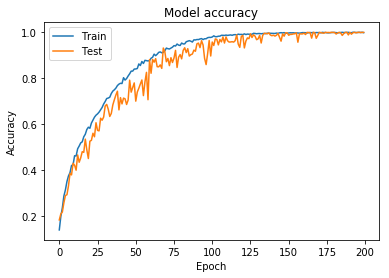

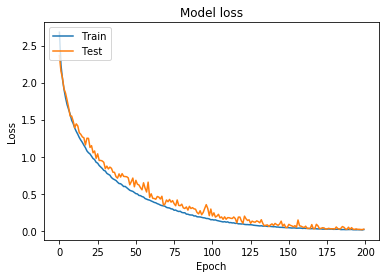

In [12]:
# Plot training & validation accuracy values (of first char only)
plt.plot(history.history['output_0_acc'])
plt.plot(history.history['val_output_0_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values (of first char only)
plt.plot(history.history['output_0_loss'])
plt.plot(history.history['val_output_0_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
nb_words_to_test = 3

x_test = create_inputs(nb_words_to_test, nb_chars, nb_letters)
print_readable_inputs(x_test)
print("x_test=\n", x_test)

x_test_scaled  = scaler.transform(x_test)
print("x_test_scaled=\n", x_test_scaled)
print('-->')

prediction = coding_model.predict(x_test_scaled)
#print(prediction)
print('prediction')
print_readable_outputs(prediction, nb_words_to_test, nb_chars)

print('check prediction')
y_test = encrypt(x_test, nb_words_to_test, nb_chars)
print("y_test=\n", y_test)

['iwoo', 'ozqb', 'glte']
x_test=
 [[105 119 111 111]
 [111 122 113  98]
 [103 108 116 101]]
x_test_scaled=
 [[-0.59767986  1.26657672  0.19941154  0.19742669]
 [ 0.20137519  1.66638279  0.46685068 -1.54075895]
 [-0.86403154 -0.19937884  0.86800938 -1.13963919]]
-->
prediction
['8 22 14 14', '14 25 16 1', '6 11 19 4']
check prediction
y_test=
 [[ 8 22 14 14]
 [14 25 16  1]
 [ 6 11 19  4]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
